# Getting Started with Spectral Clustering

In this notebook we want to explore the ideas behind spectral clustering. We do not focus on the theory, as there are many good and complete resources on the topic. For an introduction/overview I recommend the lecture notes [A Tutorial on Spectral Clustering](http://www.tml.cs.uni-tuebingen.de/team/luxburg/publications/Luxburg07_tutorial.pdf) by [Prof. Dr. Ulrike von Luxburg](http://www.tml.cs.uni-tuebingen.de/team/luxburg/index.php). For a concrete use case for this clustering method you can see PyData's tlak: [Extracting relevant Metrics with Spectral Clustering](https://www.youtube.com/watch?v=3heWpR6dC8k) by Dr. Evelyn Trautmann. 

## Prepare Notebook

In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%config InlineBackend.figure_format = 'png'

## Generate Sample Data

Let us generate some sample data. As we will see, spectral clustering is very effective for non-convext clusters. In this example, we consider concentriic circles:

In [42]:
# Set random state. 
rs = np.random.seed(25)

def generate_circle_sample_data(r, n, sigma):
    """Generate circle data with random gaussian noise."""
    angles = np.random.uniform(low=0, high=2*np.pi, size=n)

    x_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + x_epsilon
    y = r*np.sin(angles) + y_epsilon
    
    return x, y


def generate_concentric_circles_data(param_list):
    """Generates many circle data with random gaussian noise."""
    coordinates = [ 
        generate_circle_sample_data(param[0], param[1], param[2])
     for param in param_list
    ]
    
    return coordinates

Let us plot some examples to see how the parameters affect the data structure and clusters. 

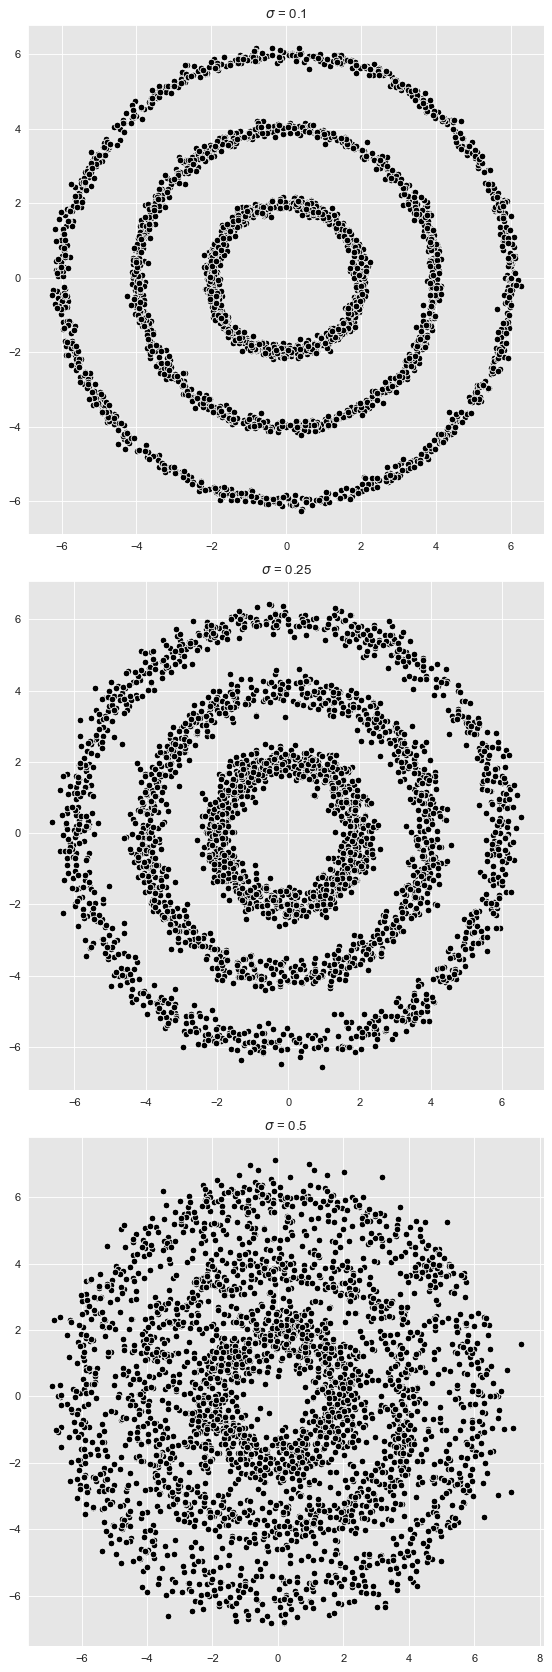

In [45]:
# Set global plot parameters. 
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 80

# Number of points per circle. 
n = 1000
# Radius. 
r_list =[2, 4, 6]
# Standar deviation gaussian noise. 
sigmas = [0.1, 0.25, 0.5]

param_lists = [[(r, n, sigma) for r in r_list] for sigma in sigmas] 
# We store the data on this list.
coordinates_list = []

fig, axes = plt.subplots(3, 1, figsize=(7, 21))

for i, param_list in enumerate(param_lists):

    coordinates = generate_concentric_circles_data(param_list)

    coordinates_list.append(coordinates)
    
    ax = axes[i]
    
    for j in range(0, len(coordinates)):
    
        x, y = coordinates[j]
        sns.scatterplot(x=x, y=y, color='black', ax=ax)
        ax.set(title=f'$\sigma$ = {param_list[0][2]}')

plt.tight_layout()

The first two plots show $3$ clear clusters. For the last one the cluster structure is less clear. 

## Spectral Clustering Algorithm

We are not going to give all the theoretical details, but we are still going to motivate the logic behind the spectral clustering algorithm. The main idea is that, given a data set, we can model its structure by a graph and then use the fact (which we will show above) that the connected components of the graph is determined by the multiplicity of the zero eigenvalue of the [graph laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix). That is, if in the graph representation of the graph we have different connected components (clusters) these can be detected by the spectrum of the graph laplacian. Asking for clusters associated with connected components can be very restrictive, nevertheless from certain stability properties of the spectrum^[A Tutorial on Spectral Clustering](http://www.tml.cs.uni-tuebingen.de/team/luxburg/publications/Luxburg07_tutorial.pdf), one can still get good clusterinig results even if the graph representing the data set is connected. 

Let us expand on the description above. Given a set of points $\{x_1, \cdots, x_n\}\subset \mathbb{R}^{k}$ we can considers its associated [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) $W \in M_{n}(\mathbb{R})$ which has a non-zero value in the $W_{ij}$ if $x_i$ is *close* to $x_j$. The notion of *close* can be taken with respect to the Euclidean metric or nearest neighbors. The graph laplacian $L \in M_{n}(\mathbb{R})$ is defined as $L:= D - W$ where $D$ is the [degree matrix](https://en.wikipedia.org/wiki/Degree_matrix) of the graph. [Here](https://juanitorduz.github.io/documents/orduz_pydata2018.pdf) you can find more details on the graph laplacian's definition and properties. 

## Example 1: Well-defined Clusters

We consider sample data with the parameters defined above with `sigma` = 0.1. Note from the plots above that in this case the clusters separate well. 

In [31]:
coordinates = coordinates_list[0]

In [32]:
from itertools import chain

def data_frame_from_coordinates(coordinates): 
    """From coordinates to data frame."""
    xs = chain(*[c[0] for c in coordinates])
    ys = chain(*[c[1] for c in coordinates])

    return pd.DataFrame(data={'x': xs, 'y': ys})

data_df = data_frame_from_coordinates(coordinates)

### K - Means

In [33]:
from sklearn.cluster import KMeans

inertias = []

k_candidates = range(1, 10)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(data_df)
    inertias.append(k_means.inertia_)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.scatterplot(x=[k_candidates[2]], y = [inertias[2]], color=sns_c[3], s=150, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

TypeError: 'NoneType' object is not subscriptable

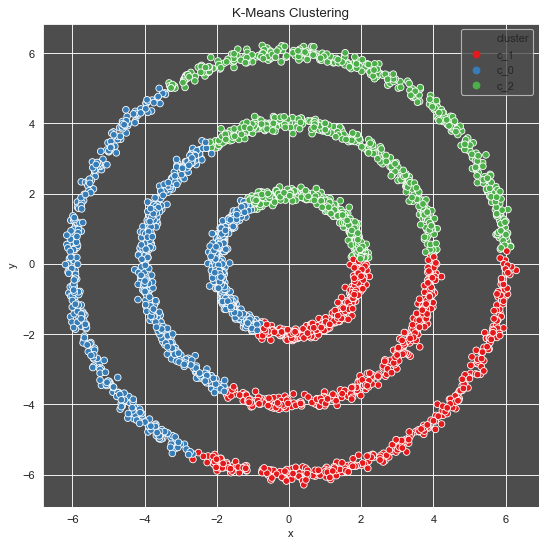

In [34]:
k_means = KMeans(random_state=25, n_clusters=3)
k_means.fit(data_df)
cluster = k_means.predict(data_df)

cluster = ['c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df.assign(cluster = cluster), hue='cluster', ax=ax)
ax.set(title='K-Means Clustering');

### Step 1: Compute Graph Laplacian

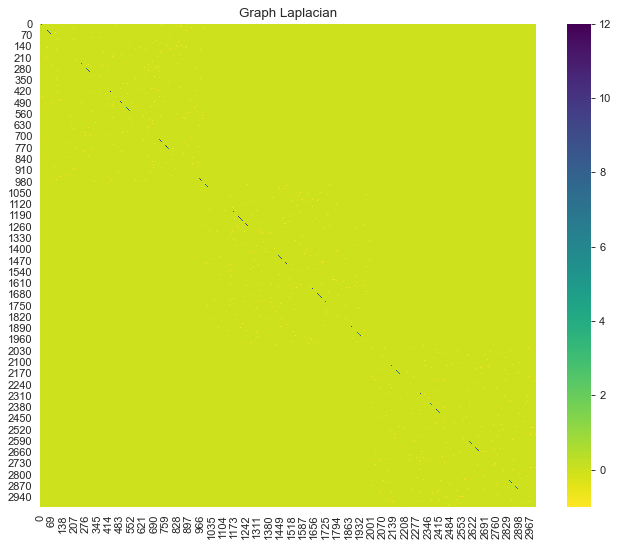

In [35]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=data_df, nn=8)

# Plot the graph laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

### Step 2: Compute Spectrum of the Graph Laplacian

Next, let us compute the eigenvalues and eigenvectors of the graph Laplacian. 

In [36]:
from scipy import linalg
eigenvals, eigenvcts = linalg.eig(graph_laplacian)

The eigenvalues are represented by complex numbers. Since the graph laplacian is a symmetric matric, we know by the [spectral theorem](https://juanitorduz.github.io/the-spectral-theorem-for-matrices/) that all the eigenvalues must be real. Let us verify this:

In [37]:
np.unique(np.imag(eigenvals))

array([0.])

In [38]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

We now compute the $L^2$-norms of the eigenvectors.

In [40]:
eigenvcts_norms = np.apply_along_axis(lambda v: np.linalg.norm(v, ord=2), axis=0, arr=eigenvcts)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 0.9999999999999997
Max Norm: 1.0000000000000002


Hence, all of the eigenvectors have length ~ 1.

In [41]:
#eigenvals, eigenvcts = sparse.linalg.eigs(A=graph_laplacian_s, k=200)

Next, we sort the eigenvalues in ascending order.

In [42]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

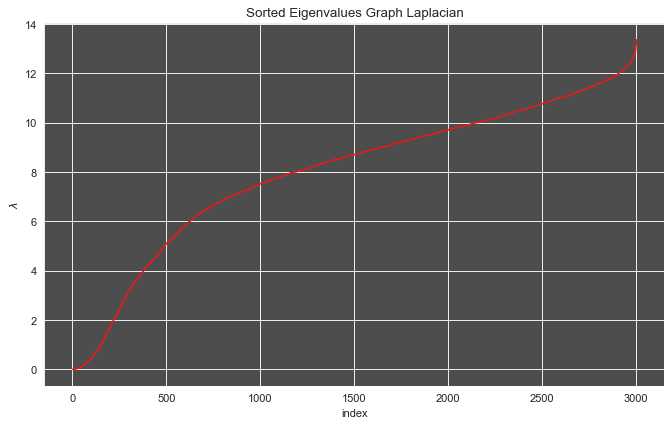

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

### Step 3: Find the Small Eigenvalues 

Let us zoom in into small eigenvalues.

In [44]:
index_lim = 10

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
ax.axvline(x=3, color=sns_c[3], label='zero egenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

TypeError: 'NoneType' object is not subscriptable

From the plot we see see that the first 3 eigenvalues (sorted) are essentially zero.

In [45]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5)
eigenvals[zero_eigenvals_index]

array([[-9.42076177e-16],
       [ 8.21825247e-16],
       [ 5.97249344e-16]])

For these small eigenvalues, we consider their corresponding eigenvectors.

In [46]:
proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]

proj_df.head()

,v_0,v_1,v_2
0,0.031623,0.0,0.0
1,0.031623,0.0,0.0
2,0.031623,0.0,0.0
3,0.031623,0.0,0.0
4,0.031623,0.0,0.0


In [47]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corrsponding to the first 
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

### Step 4: Run K-Means Clustering

To select the number of clusters to select we run k-menans for various cluster values and plot the associated inertia (sum of squared distances of samples to their closest cluster center).

In [48]:
inertias = []

k_candidates = range(1, 6)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)

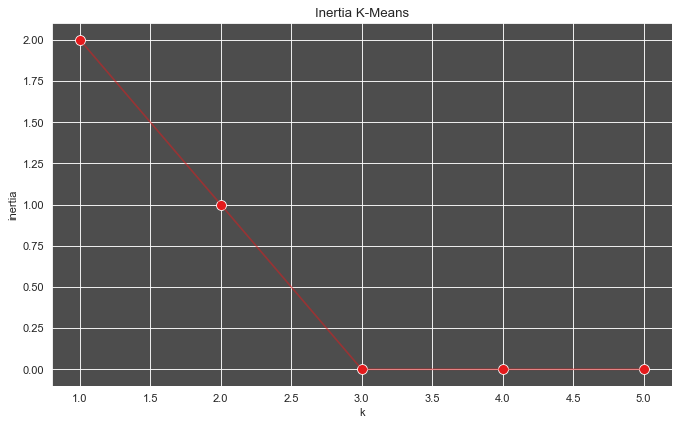

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

From this plot we see that the optomal number of clusters is $k=3$.

In [50]:
def run_k_means(df, n_clusters):
    """K-means clustering."""
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster

cluster = run_k_means(proj_df, n_clusters=3)

### Step 5: Assing Cluster Tag

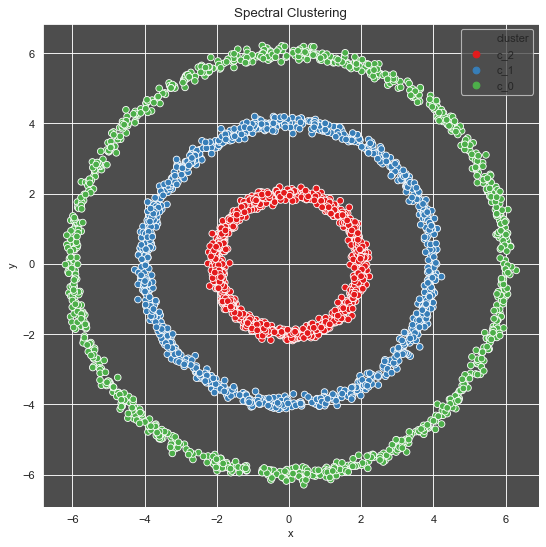

In [51]:
data_df['cluster'] = ['c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

### Summary 

In [52]:
def spectral_clusterinig(df, n_neighbors, n_clusters):
    """Spectral Clustering Algorithm."""
    graph_laplacian = generate_graph_laplacian(df, n_neighbors)
    eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)
    proj_df = project_and_transpose(eigenvals, eigenvcts, n_clusters)
    cluster = run_k_means(proj_df, proj_df.columns.size)
    return ['c_' + str(c) for c in cluster]

## Example 2

- 3 Clusters

In [53]:
data_df = data_frame_from_coordinates(coordinates_list[1])
data_df['cluster'] = spectral_clusterinig(df=data_df, n_neighbors=8, n_clusters=3)

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

KeyboardInterrupt: 

- 2 Clusters

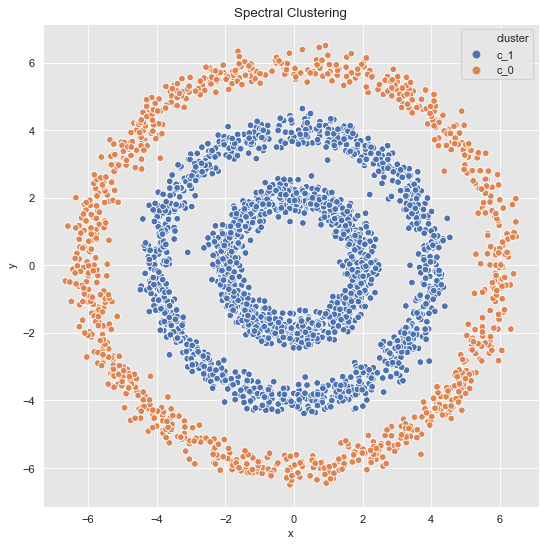

In [26]:
data_df = data_frame_from_coordinates(coordinates_list[1])
data_df['cluster'] = spectral_clusterinig(df=data_df, n_neighbors=8, n_clusters=2)

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

## Example 3

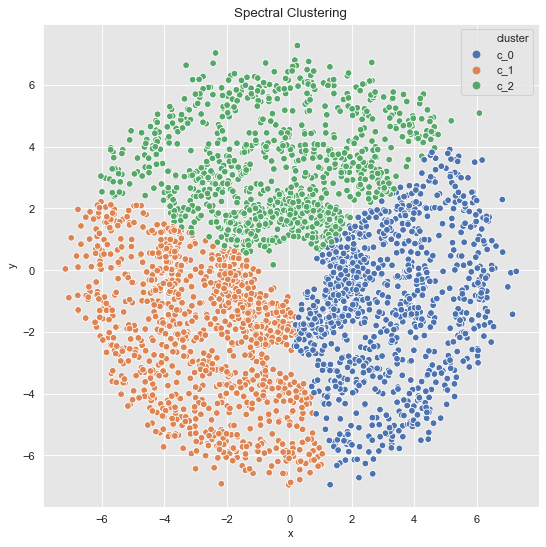

In [27]:
data_df = data_frame_from_coordinates(coordinates_list[2])
data_df['cluster'] = spectral_clusterinig(df=data_df, n_neighbors=8, n_clusters=3)

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

## SpectralClustering (Scikit-Learn)

### Example 2 (Revisited)

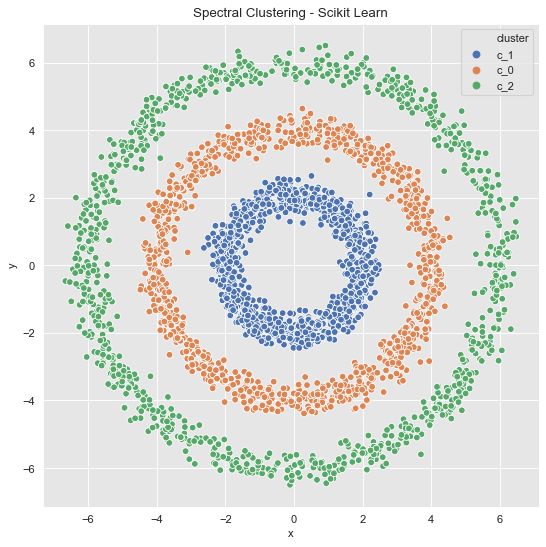

In [28]:
from sklearn.cluster import SpectralClustering

data_df = data_frame_from_coordinates(coordinates_list[1])

spec_cl = SpectralClustering(
    n_clusters=3, 
    random_state=25, 
    n_neighbors=8, 
    affinity='nearest_neighbors'
)

data_df['cluster'] = spec_cl.fit_predict(data_df[['x', 'y']])
data_df['cluster'] = ['c_' + str(c) for c in data_df['cluster']]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering - Scikit Learn');

### Example 3 (Revisited)

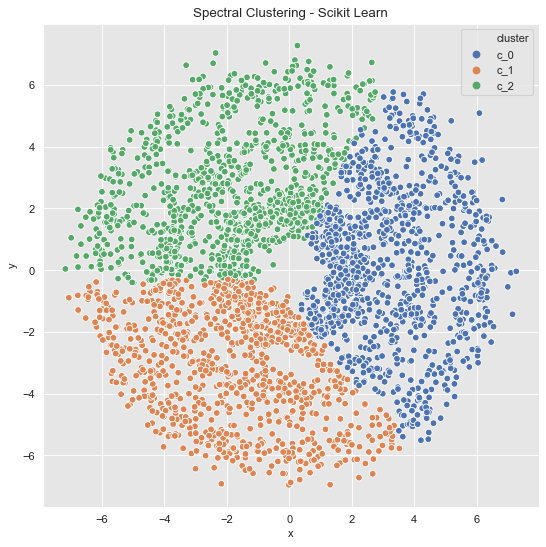

In [29]:
data_df = data_frame_from_coordinates(coordinates_list[2])

spec_cl = SpectralClustering(
    n_clusters=3, 
    random_state=42, 
    n_neighbors=8, 
    affinity='nearest_neighbors'
)

data_df['cluster'] = spec_cl.fit_predict(data_df[['x', 'y']])
data_df['cluster'] = ['c_' + str(c) for c in data_df['cluster']]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering - Scikit Learn');